# Importing

## Importing modules

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, adagrad, rmsprop


## importing own code

In [21]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

In [22]:
def trainNetwork(network, trainingData, validationSplit, numberOfEpochs=50, batchSize=32, verboseSetting=-1):
    """
    hjhgj
    
    network is the Keras network to be trained.
    trainingData is the data to be trained with. It is a tupple with the index zero being the input data and index one being the target/output value.
    validationData is the data used to do validation.  It is a tupple with the index zero being the input data and index one being the target/output value.
    numberOfEpochs is the number of epochs the model will train for default is 50.
    batchSize is the size of the batches during gradiant decent defaul is 32.
    verboseSettings are the verbose settings default is -1 (which does nothing), 0 results in plots and above that normal rules apply.
    """
    
    #print(np.shape(trainingData[0]))
    #print(np.shape(trainingData[0][0]))
    #print(np.shape(trainingData[1]))
    
    #print(trainingData[0])
    
    fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split = validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))
    
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    if verboseSetting>=0:
        
        maximumValue = max(max(history['loss']), max(history['val_loss']))
        minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax1.legend()
        ax1.set_xlim(1, numberOfEpochs)
        ax1.set_ylim(0, maximumValue)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss (training and validation) vs the number of epochs.')
        
        ax2.plot(history['loss'], history['val_loss'])
        ax2.set_xlim(0, maximumValue)
        ax2.set_ylim(0, maximumValue)
        ax2.set_xlabel('Training loss')
        ax2.set_ylabel('Validation loss')
        ax2.set_title('Validation loss vs training loss.')
        
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax3.legend()
        ax3.set_xlim(1, numberOfEpochs)
        ax3.set_yscale('log')
        ax3.set_ylim(minimumValue, maximumValue)
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Loss')
        ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
        
        ax4.plot(history['loss'], history['val_loss'])
        ax4.set_xscale('log')
        ax4.set_xlim(minimumValue, maximumValue)
        ax4.set_yscale('log')
        ax4.set_ylim(minimumValue, maximumValue)
        ax4.set_xlabel('Training loss')
        ax4.set_ylabel('Validation loss')
        ax4.set_title('Validation loss vs training loss (logarithmic).')
        
        math.pow(math.log(min(min(history['loss']), min(history['val_loss'])), 10), 10)
        
        plt.show()
        history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [23]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)

In [24]:
def makeNetwork(inputSize, settings, learningRate, lossFunction='MAE', kernalInitializer='he_uniform'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3]))#, kernel_initializer=kernalInitializer))
    model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        if setting[0]=='Dense':# 1 is amount of nodes, 2 is kind of activation, 3 is bias
            model.add(Dense(setting[1], use_bias=setting[3]))#, kernel_initializer=kernalInitializer))
            model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model

# Getting data

In [25]:
filename = 'combinedDataR500M1M2Prepared'#'combinedDataPrepared'
inputSize = 8
orderOfMatrix = False# Make a list if you want to do the calculations yourself and make a other type of you want to import it

if (type(orderOfMatrix) == list):
    dataRaw = pd.read_json(filename + '.json', orient='columns')
    dataRaw['particleCoordinates'] = dataRaw['particleCoordinates'].apply(np.array)
    data = prepareDatabseForMachineLearningMultiprocessing(dataRaw, orderOfMatrix, filename + 'Prepared', amountOfCores)
    #data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
else:
    data = pd.read_json(filename + '.json', orient='columns')
    data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
    #data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
    #data['eigenvalues'] = data['eigenvalues'].apply(list)

In [26]:
#data.head()

In [27]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,400000.000000,400000.000000,400000.0,4.000000e+05
mean,199999.500000,127.440706,4.0,3.518502e+13
std,115470.198175,70.767268,0.0,1.831137e+16
min,0.000000,5.000726,4.0,-3.849714e-03
25%,99999.750000,66.011352,4.0,-4.700000e-09
50%,199999.500000,127.548477,4.0,1.121000e-07
75%,299999.250000,188.691601,4.0,1.985967e-04
max,399999.000000,249.998993,4.0,1.140523e+19


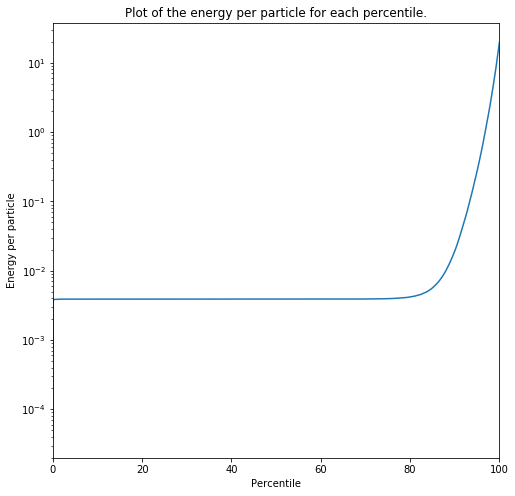

In [28]:
offset = 0#min(data['potentialEnergy'])
data['potentialEnergy'] = data['potentialEnergy']-offset
#qLow = data['potentialEnergy'].quantile(0.00001)
qHi  = data['potentialEnergy'].quantile(0.95)
dataFiltered = data[(data['potentialEnergy'] < qHi)]# & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()

data = dataFiltered

In [29]:
#data.head()

In [30]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,380000.000000,380000.000000,380000.0,3.800000e+05
mean,199919.256079,132.826143,4.0,1.934710e-01
std,115472.282225,68.062680,0.0,1.303153e+00
min,0.000000,6.189629,4.0,-3.849714e-03
25%,99907.750000,74.280118,4.0,-5.600000e-09
50%,199830.500000,133.356626,4.0,4.905000e-08
75%,299908.250000,191.645920,4.0,5.638020e-05
max,399999.000000,249.998993,4.0,1.944291e+01


In [31]:
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(trainingData['potentialEnergy'][i])

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]

## Preparing testing

No handles with labels found to put in legend.


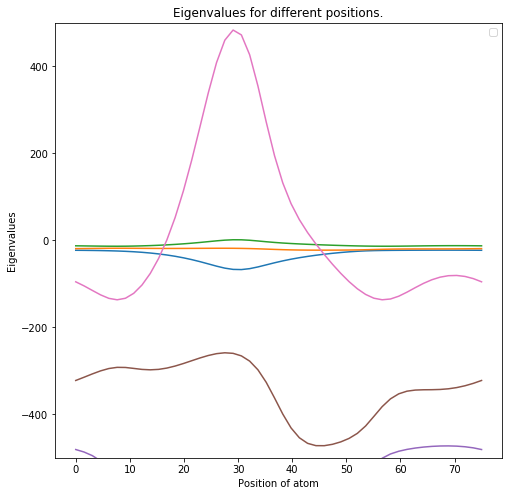

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,50.00000,50.0,50.0,5.000000e+01
mean,24.50000,75.0,4.0,8.421215e-05
std,14.57738,0.0,0.0,2.100455e-04
min,0.00000,75.0,4.0,-8.960598e-07
25%,12.25000,75.0,4.0,-8.544991e-07
50%,24.50000,75.0,4.0,-6.895119e-07
75%,36.75000,75.0,4.0,1.558068e-05
max,49.00000,75.0,4.0,8.610011e-04


In [32]:
#"""
widthOfCell = 5*15.0
numberOfSurroundingCells = 4
R0 = 500
orderOfMatrix = [-1, -2]
x = np.linspace(0, 1, 50)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.3, 0.5]), np.array([0.9, 0.9]), np.array([0.6, 0.4]), np.array([0.5, i])]
    #particles = [np.array([0.3, 0.5]), np.array([0.3, 0.4]), np.array([0.6, 0.4]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

#for i in range(len(x)):
#    print(testData['eigenvalues'][i])

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(len(testData['eigenvalues']))])
ax1.legend()
ax1.set_ylim(-500, 500)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()
#"""

# Machine learning

In [33]:
models = []

## Model 1

In [34]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              8192      
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1024      
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 9,216
Trainable params: 9,216
Non-trainable params: 0
_________________________________________________________________


Train on 212800 samples, validate on 91200 samples
Epoch 1/50
212800/212800 [==============================] - 13s 63us/step - loss: 34.0702 - val_loss: 13.5649
Epoch 2/50
212800/212800 [==============================] - 13s 61us/step - loss: 20.0233 - val_loss: 6.9267
Epoch 3/50
212800/212800 [==============================] - 13s 61us/step - loss: 9.8910 - val_loss: 15.9661
Epoch 4/50
212800/212800 [==============================] - 13s 63us/step - loss: 4.3056 - val_loss: 1.3443
Epoch 5/50
212800/212800 [==============================] - 13s 62us/step - loss: 1.7431 - val_loss: 0.6590
Epoch 6/50
212800/212800 [==============================] - 13s 62us/step - loss: 0.6079 - val_loss: 0.1983
Epoch 7/50
212800/212800 [==============================] - 13s 62us/step - loss: 0.1775 - val_loss: 0.1146
Epoch 8/50
212800/212800 [==============================] - 13s 62us/step - loss: 0.1194 - val_loss: 0.2149
Epoch 9/50
212800/212800 [==============================] - 14s 64us/step - loss:

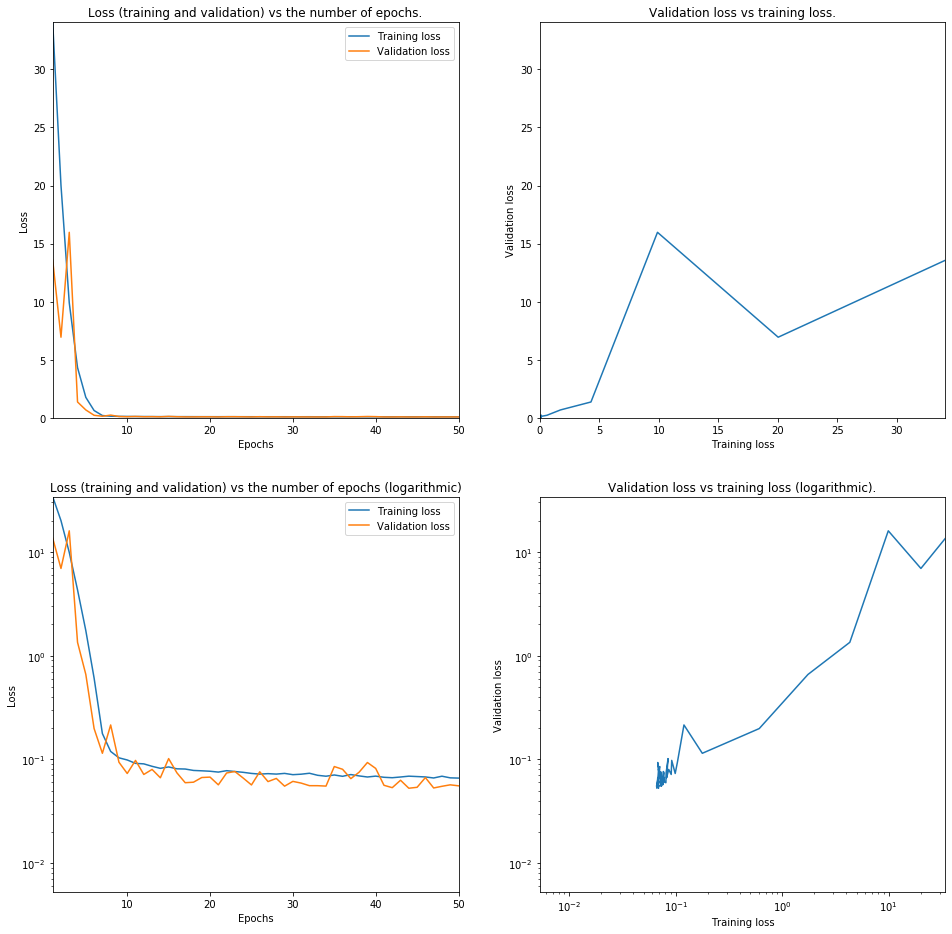

In [35]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=50, batchSize=32, verboseSetting=1)
models.append([model, 'model1'])
print()

76000/76000 [==============================] - 2s 23us/step
0.05580559364659635


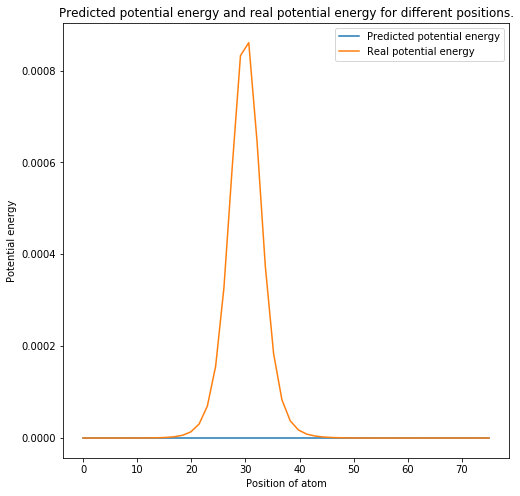

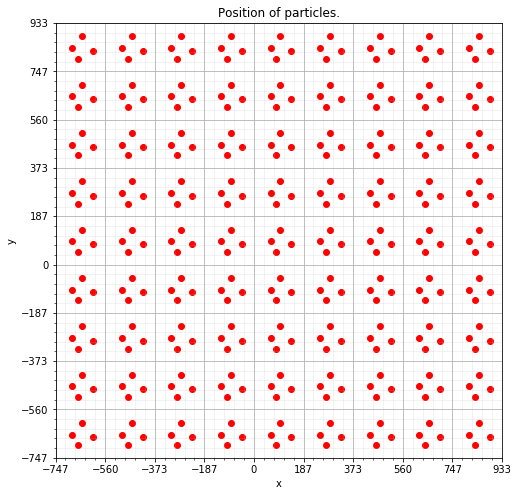

For index 0 Predicted -1.4210066e-13 was -5.4e-09


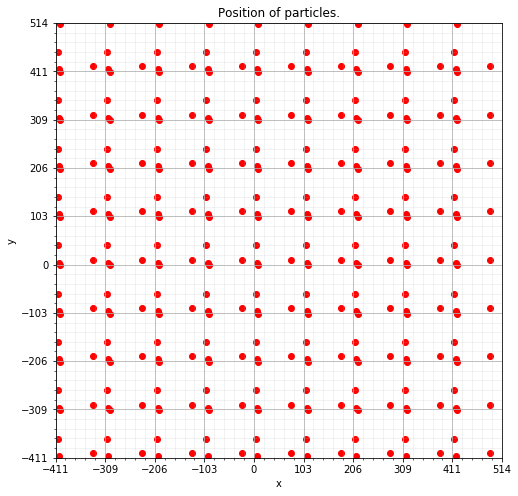

For index 1 Predicted 0.0 was 0.0030937265


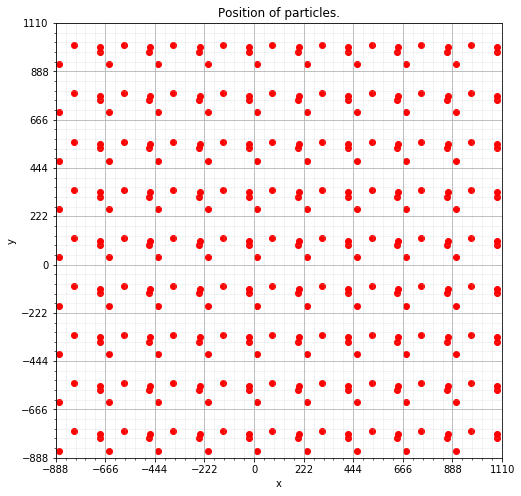

For index 3 Predicted 2.6446266e-13 was 3.2100000000000003e-07


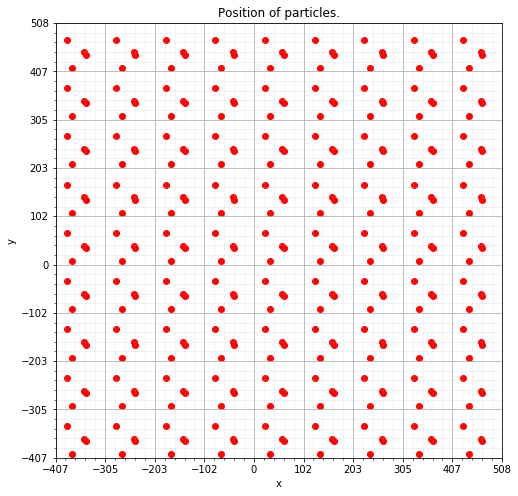

For index 39 Predicted 0.0 was 0.0037180505000000003


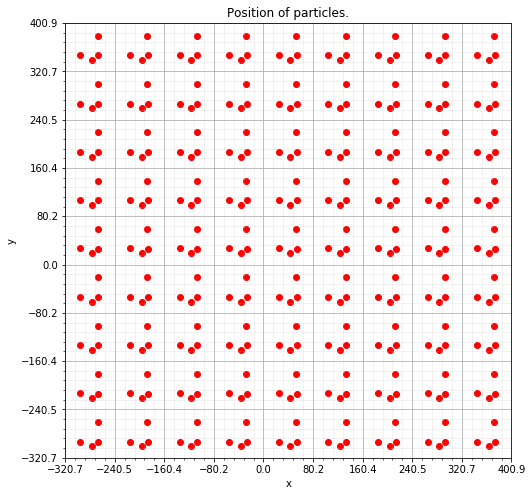

For index 43 Predicted 0.0 was 1.20419e-05


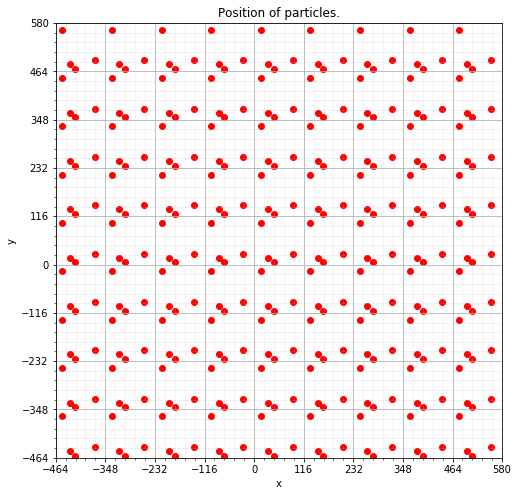

For index 44 Predicted -8.6151117e-32 was 9.073000000000001e-07


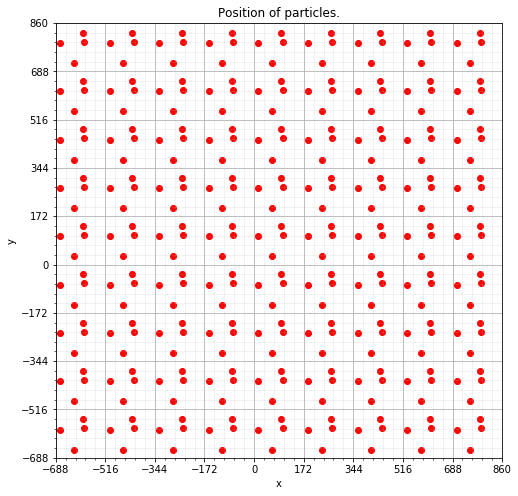

For index 55 Predicted -6.4370802e-15 was -6e-10


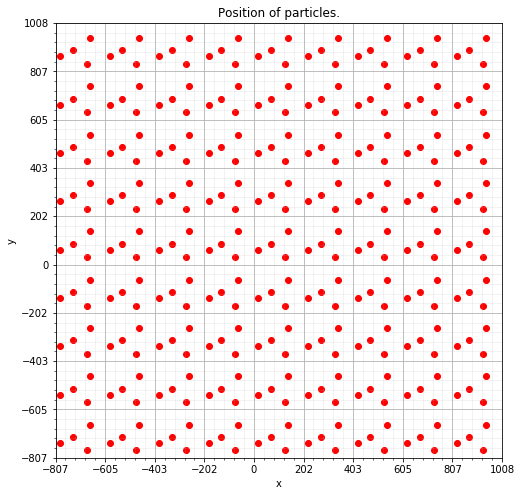

For index 64 Predicted -3.8810236e-11 was -2.5e-09


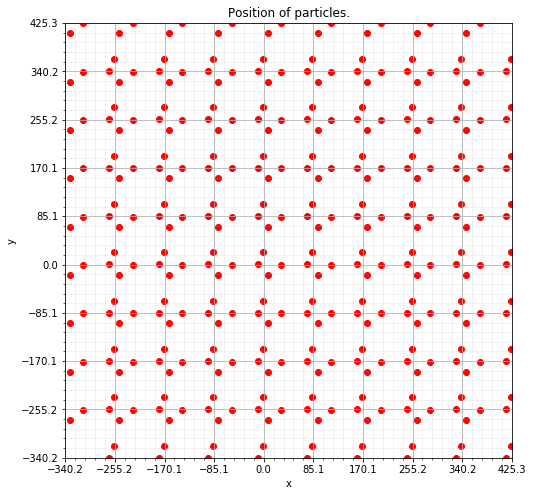

For index 67 Predicted 0.0 was -6.032e-07


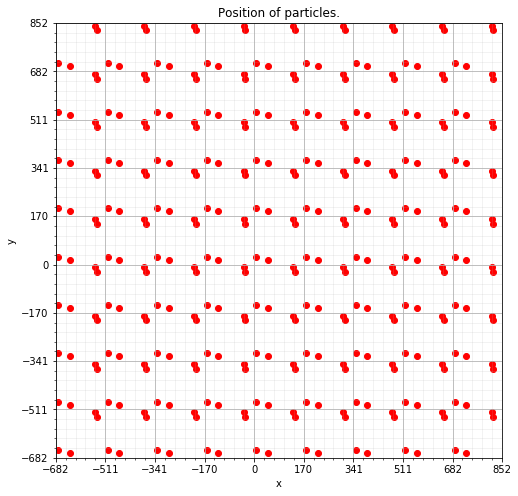

For index 68 Predicted -1.0693936e-21 was 7.18e-07



In [36]:
#model = models[0][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 2

In [37]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2048)              16384     
_________________________________________________________________
activation_7 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2048      
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 18,432
Trainable params: 18,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=50, batchSize=32, verboseSetting=1)
models.append([model, 'model2'])
print()

Train on 212800 samples, validate on 91200 samples
Epoch 1/50
212800/212800 [==============================] - 13s 63us/step - loss: 38.6547 - val_loss: 33.9258
Epoch 2/50
212800/212800 [==============================] - 14s 64us/step - loss: 12.2282 - val_loss: 1.7028
Epoch 3/50
212800/212800 [==============================] - 14s 68us/step - loss: 3.0282 - val_loss: 0.9047
Epoch 4/50
212800/212800 [==============================] - 14s 65us/step - loss: 0.4264 - val_loss: 0.1835
Epoch 5/50
212800/212800 [==============================] - 14s 64us/step - loss: 0.1661 - val_loss: 0.1909
Epoch 6/50
212800/212800 [==============================] - 15s 72us/step - loss: 0.1930 - val_loss: 0.1909
Epoch 7/50
212800/212800 [==============================] - 14s 66us/step - loss: 0.1930 - val_loss: 0.1909
Epoch 8/50
212800/212800 [==============================] - 13s 63us/step - loss: 0.1930 - val_loss: 0.1909
Epoch 9/50
212800/212800 [==============================] - 14s 66us/step - loss: 

In [ ]:
#model = models[1][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 3

In [ ]:
settings = [['Dense', 1024, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=50, batchSize=32, verboseSetting=1)
models.append([model, 'model3'])
print()

In [ ]:
#model = models[2][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 4

In [ ]:
settings = [['Dense', 2048, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=50, batchSize=32, verboseSetting=1)
models.append([model, 'model4'])
print()

In [ ]:
#model = models[3][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 5

In [ ]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=50, batchSize=32, verboseSetting=1)
models.append([model, 'model5'])
print()

In [ ]:
#model = models[4][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 6

In [ ]:
settings = [['Dense', 4096, 'softplus', False], ['Dense', 4096, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=50, batchSize=32, verboseSetting=1)
models.append([model, 'model6'])
print()

In [ ]:
#model = models[5][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 7

In [ ]:
settings = [['Dense', 2048, 'softplus', True], ['Dense', 2048, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=50, batchSize=32, verboseSetting=1)
models.append([model, 'model7'])
print()

In [ ]:
#model = models[6][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 8

In [ ]:
settings = [['Dense', 4096, 'softplus', True], ['Dense', 4096, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=50, batchSize=32, verboseSetting=1)
models.append([model, 'model8'])
print()

In [ ]:
#model = models[7][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Saving a model

In [ ]:
model = model[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')